# Hacking WORDL using AI

## Intro

### What is WORDL?
On the off-chance you haven't heard about wordl, it is essentially a word guessing game. You get **6** attempts to guess a **5** letter word.
Whenever you make a guess, WORDL gives you feedback on each letter, by color coding their background:
1. Grey: The word we are looking for does not contain this letter
1. Yellow: The letter is in the word but in the wrong spot
1. Green: Nice! The letter and position of the letter are correct.

## Approach

Two approaches:
1. 'Blind Approach': contains all 5 letter words of the english language
1. 'Biased Approach': contains all words wordl actually uses

## What's needed

### Knowledge
We need to know 5 letter words of the english language

### 

## Code

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get dictionary with 5 letter words
with open(file='words.txt', mode='r') as f:
    lines = f.readlines()
f.close()

lines = [l.strip() for l in lines]

df_words = pd.DataFrame(lines, columns=['word'])

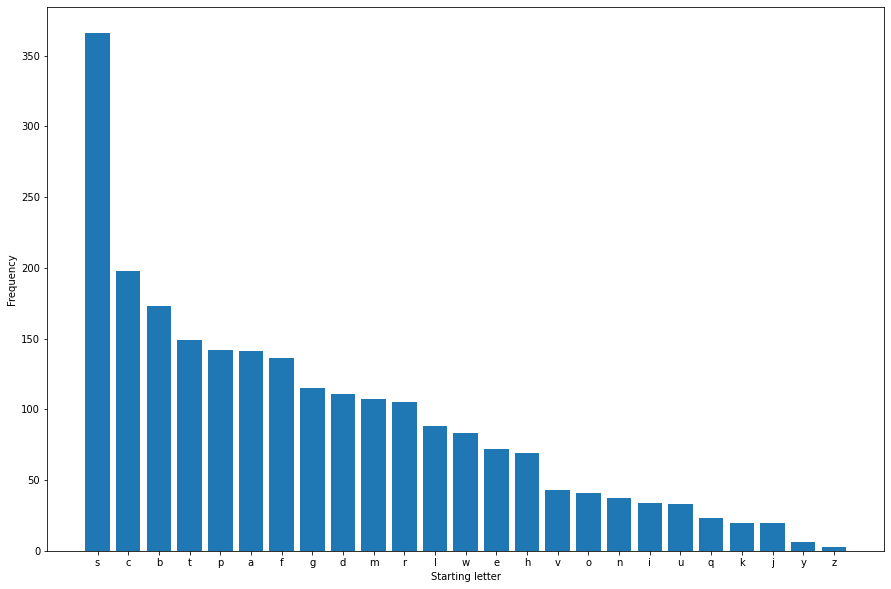

In [3]:
# Statistics

# Words --> Letters
df_words_letters = pd.DataFrame([[l for l in w] for w in df_words['word']])
# starting letter
fig, ax = plt.subplots(1, figsize=(15, 10))
_ = ax.bar(x=df_words_letters[0].value_counts().index, height=df_words_letters[0].value_counts())
_ = ax.set_xlabel('Starting letter')
_ = ax.set_ylabel('Frequency')

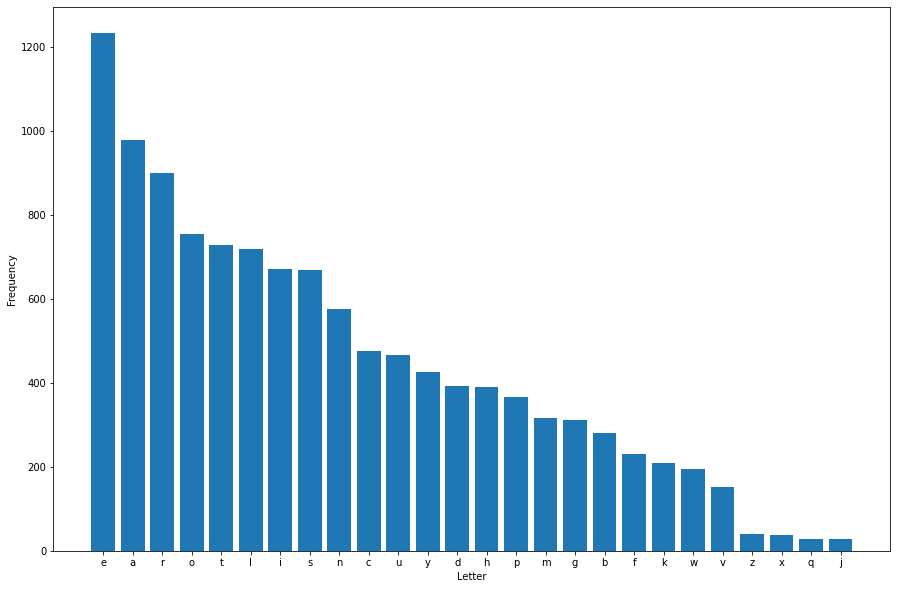

In [4]:
# letter distribution within words
letter_count = dict()

for w in df_words['word']:
    for l in w:
        if l in letter_count.keys():
            letter_count[l] += 1
        else: letter_count[l] = 1

df_letter_freq = pd.DataFrame.from_dict(letter_count, orient='index', columns=['frequency']).sort_values(by='frequency', ascending=False)

fig, ax = plt.subplots(1, figsize=(15, 10))
_ = ax.bar(x=df_letter_freq.index, height=df_letter_freq['frequency'])
_ = ax.set_xlabel('Letter')
_ = ax.set_ylabel('Frequency')

In [5]:
# so we should initially guess a word starting with S and containing most of the top letters
df_words[df_words['word'].str.startswith('sal')]

,word
1635,salad
1636,sally
1637,salon
1638,salsa
1639,salty
1640,salve
1641,salvo


## Wordl Code

In [220]:
class Wordle:
    def __init__(self, wordlist, max_guesses: int = 6):
        self.wordlist: list = wordlist
        self.word: str = np.random.choice(wordlist)
        self.guesses: list = list()
        self.max_guesses: int = max_guesses
        self.game_state: str = 'ONGOING'
    
    def state(self):
        if len(self.guesses) > self.max_guesses: self.game_state = 'LOSS'
        elif self.word in self.guesses: self.game_state = 'WIN'
        else: self.game_state = 'ONGOING'

    def guess(self, guess: str):
        assert guess not in self.guesses
        self.guesses.append(guess)
        results = list()
        for guessed_letter, actual_letter in zip(guess, self.word):
            if guessed_letter == actual_letter: results.append('GREEN')
            elif guessed_letter in self.word: results.append('YELLOW')
            else: results.append('GREY')
        self.state()
        return tuple((p, l, r) for (p, r), l  in zip(enumerate(results), guess)) # position, letter, result

## Guesser

### Random Guesser

In [249]:
# Random Guesser
class RandomGuesser:
    def __init__(self, wordlist: list):
        self.wordlist = wordlist
        self.guesses: list = list()
        
    def make_guess(self):
        for i in range(len(self.wordlist)):
            guess = self.wordlist[i]
            if not guess in self.guesses:
                self.guesses.append(guess)
                return guess

In [264]:
class Knowledge:
    def __init__(self):
        self.correct_letters: set = set()
        self.possible_letters: list = [set("abcdefghijklmnopqrstuvwxyz") for i in range(5)]

    def update(self, update):
        for p, l, r in update:
            if r == 'GREY': [self.possible_letters[i].remove(l) for i in range(5) if l in self.possible_letters[i]]
            elif r == 'YELLOW':
                if l in self.possible_letters[p]: self.possible_letters[p].remove(l)
                self.correct_letters.add(l)
            else: 
                self.possible_letters[p] = set(l)
                self.correct_letters.add(l)

In [271]:
class UpdatedRandomGuesser:
    def __init__(self, wordlist: list):
        self.wordlist = wordlist
        self.guesses: list = list()

    def make_guess(self, knowledge):
        for i in range(len(self.wordlist)):
            guess = self.wordlist[i]
            # check if guess is possible according to knowledge
            # 1) Do the guess letters contain the correct letters?
            # 2) Is the positioning of the letters possible?
            guess_contains_correct_letters = knowledge.correct_letters.issubset(set(guess))
            guess_letter_positions_possible = True
            for pos, let in enumerate(guess):
                if let not in knowledge.possible_letters[pos]: guess_letter_positions_possible = False
            if not guess in self.guesses and guess_contains_correct_letters and guess_letter_positions_possible:
                self.guesses.append(guess)
                return guess

## Let's Play!

In [314]:
result = list()
rg_attempt = list()
for i in range(1000):
    w = Wordle(wordlist=df_words['word'])
    rg = RandomGuesser(wordlist=df_words['word'])
    while w.game_state == 'ONGOING':
        guess = rg.make_guess()
        w.guess(guess)
    result.append(w.game_state)
    rg_attempt.append(len(w.guesses))

df_rg = (pd.DataFrame(result, dtype=str)
        .value_counts()
        .to_frame()
        .rename_axis(index=None, columns=None)
        .rename({0:'freq'}, axis=1)
        .reset_index()
        .rename({'level_0': 'state'}, axis=1)
      )
df_rg

,state,freq
0,LOSS,998
1,WIN,2


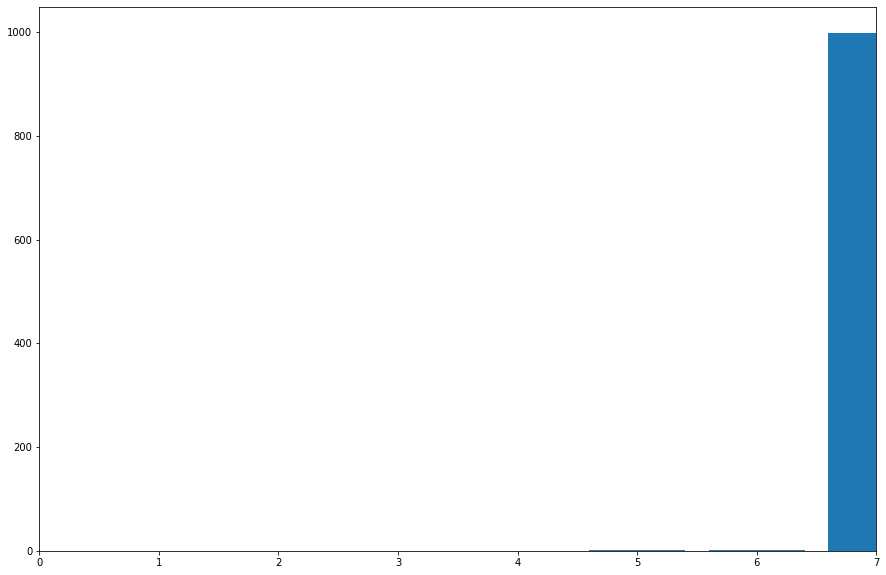

In [327]:
df_rg_attempts = pd.DataFrame(rg_attempt).value_counts().to_frame().rename_axis(index=None, columns=None).reset_index().rename({0: 'freq', 'level_0': 'attempts'}, axis=1)
fig, ax = plt.subplots(1, figsize=(15, 10))
_ = ax.bar(x=df_rg_attempts['attempts'], height=df_rg_attempts['freq'])
_ = ax.set_xlim(0, 7)

In [319]:
result = list()
urg_attempt = list()
for i in range(1000):
    w = Wordle(wordlist=df_words['word'])
    urg = UpdatedRandomGuesser(wordlist=df_words['word'])
    knowledge = Knowledge()
    while w.game_state == 'ONGOING':
        guess = urg.make_guess(knowledge=knowledge)
        r = w.guess(guess)
        knowledge.update(r)
    result.append(w.game_state)
    urg_attempt.append(len(w.guesses))

df_urg = (pd.DataFrame(result, dtype=str)
        .value_counts()
        .to_frame()
        .rename_axis(index=None, columns=None)
        .rename({0:'freq'}, axis=1)
        .reset_index()
        .rename({'level_0': 'state'}, axis=1)
      )
df_urg

,state,freq
0,WIN,966
1,LOSS,34


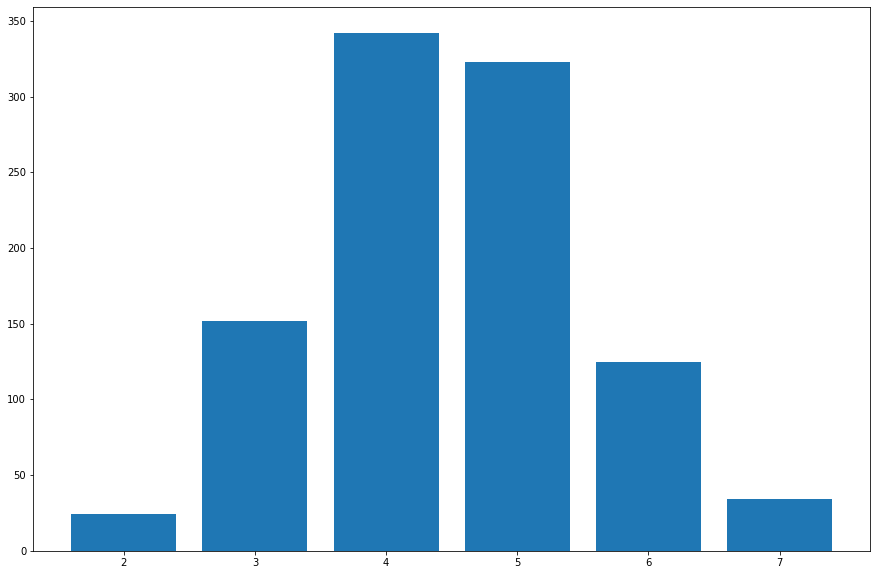

In [329]:
df_urg_attempts = pd.DataFrame(urg_attempt).value_counts().to_frame().rename_axis(index=None, columns=None).reset_index().rename({0: 'freq', 'level_0': 'attempts'}, axis=1)
fig, ax = plt.subplots(1, figsize=(15, 10))
_ = ax.bar(x=df_urg_attempts['attempts'], height=df_urg_attempts['freq'])